<a href="https://colab.research.google.com/github/Moniselvam14/E-commerce-project/blob/main/E_commerce_Product_recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **E-commerce Product recommendation System**


**Importing libraries**


In [39]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import mean_squared_error

from scipy.sparse.linalg import svds # for sparse matrices

**Importing Dataset**

In [40]:
#Import the data set
df = pd.read_csv('ratings_Beauty.csv')

df = df.drop('Timestamp', axis=1) #Dropping timestamp

df_copy = df.copy(deep=True) #Copying the data to another dataframe

**EDA**

In [41]:
rows, columns = df.shape
print("No of rows = ", rows)
print("No of columns = ", columns)

No of rows =  1048575
No of columns =  3


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   UserId     1048575 non-null  object
 1   ProductId  1048575 non-null  object
 2   Rating     1048575 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 24.0+ MB


In [5]:
df.isna().sum()

UserId       0
ProductId    1
Rating       1
dtype: int64

In [6]:
df['Rating'].describe()

count    52770.000000
mean         4.167349
std          1.317201
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: Rating, dtype: float64

Rating distribution


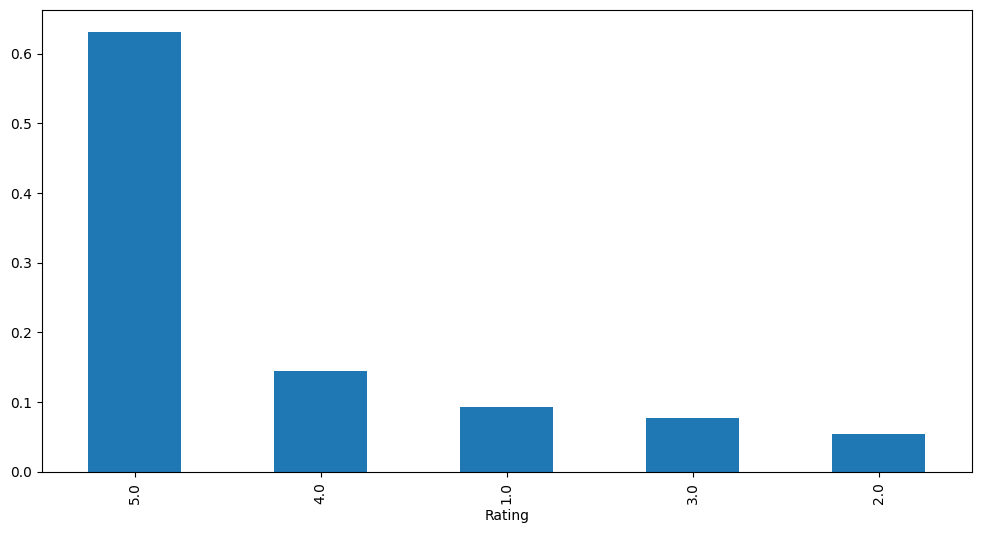

In [7]:
plt.figure(figsize = (12,6))
df['Rating'].value_counts(1).plot(kind='bar')
plt.show()

# **No of unique users and items**

In [8]:
print('Number of unique USERS in Raw data = ', df['UserId'].nunique())
print('Number of unique ITEMS in Raw data = ', df['ProductId'].nunique())

Number of unique USERS in Raw data =  49597
Number of unique ITEMS in Raw data =  2694


# **New SectioUsers with most no of rating**

In [9]:
most_rated = df.groupby('UserId').size().sort_values(ascending=False)[:10]
most_rated

UserId
A281NPSIMI1C2R    42
A1Z54EM24Y40LL    25
A3M174IC0VXOS2    23
AK7CAW3N1XZV6     15
AKMEY1BSHSDG7     14
A1BG8QW55XHN6U    13
A2B7BUH8834Y6M    11
A1IU7S4HCK1XK0    10
A22VW0P4VZHDE3     9
A22ZFXQE8AWPEP     9
dtype: int64

# **Pre-Processing**

In [62]:
counts = df['UserId'].value_counts()
df_final = df[df['UserId'].isin(counts[counts >= 50].index)]

In [63]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['UserId'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['ProductId'].nunique())

The number of observations in the final data = 5036
Number of unique USERS in the final data =  58
Number of unique PRODUCTS in the final data =  4290


# **Checking the density of the rating matrix**

In [64]:
#Creating the interaction matrix of products and users based on ratings and replacing NaN value with 0
final_Rating_matrix = df_final.pivot(index = 'UserId', columns ='ProductId', values = 'Rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_Rating_matrix.shape)

#Finding the number of non-zero entries in the interaction matrix
given_num_of_Rating = np.count_nonzero(final_Rating_matrix)
print('given_num_of_Rating = ', given_num_of_Rating)

#Finding the possible number of ratings as per the number of users and products
possible_num_of_Rating = final_Rating_matrix.shape[0] * final_Rating_matrix.shape[1]
print('possible_num_of_Rating = ', possible_num_of_Rating)

#Density of ratings
density = (given_num_of_Rating/possible_num_of_Rating)
density *= 100
print ('density: {:4.2f}%'.format(density))

final_Rating_matrix.head()

Shape of final_ratings_matrix:  (58, 4290)
given_num_of_Rating =  5036
possible_num_of_Rating =  248820
density: 2.02%


ProductId,5357954771,9788073476,9788073840,9788074421,9790786948,9790794231,979079634X,9790798695,9832114276,B00000JGVX,...,B003G1CE5Y,B003G8JWW0,B003GC4GHM,B003GDK6F2,B003GLJ6PA,B003GMHUB6,B003GVCU62,B003H2MR2W,B003H6H6X8,B003H8180I
UserId,,,,,,,,,,,,,,,,,,,,,
A12PH6L5QSVTYN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A132ETQPMHQ585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A19UTUEBWKIZFT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1EAX5HVYV96EF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1HOPKK8E3MIX6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **Rank Based Recommendation System**

In [65]:

#Calculate the average rating for each product
average_rating = df_final.groupby('ProductId')['Rating'].mean()

#Calculate the count of ratings for each product
count_rating = df_final.groupby('ProductId').count()['Rating']

#Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

#Sort the dataframe by average of ratings
final_rating = final_rating.sort_values(by='avg_rating',ascending=False)

final_rating.head()

,avg_rating,rating_count
ProductId,,
5357954771,5.0,1
B0015IW3PG,5.0,1
B00155WKXY,5.0,1
B00157DO4Q,5.0,1
B00158G7YO,5.0,1


In [66]:
#defining a function to get the top n products based on highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):

    #Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count']>min_interaction]

    #Sorting values w.r.t average rating
    recommendations = recommendations.sort_values('avg_rating',ascending=False)

    return recommendations.index[:n]

# **Recommending top 5 products with 50 minimum interactions based on popularity**

In [67]:
list(top_n_products(final_rating, 5, 50))

[]

# **Recommending top 5 products with 100 minimum interactions based on popularity**

In [68]:
list(top_n_products(final_rating, 5, 100))

[]

# **Collaborative Filtering based Recommendation System**

# **User based collaborative filtering**

In [69]:
final_Rating_matrix.head()

ProductId,5357954771,9788073476,9788073840,9788074421,9790786948,9790794231,979079634X,9790798695,9832114276,B00000JGVX,...,B003G1CE5Y,B003G8JWW0,B003GC4GHM,B003GDK6F2,B003GLJ6PA,B003GMHUB6,B003GVCU62,B003H2MR2W,B003H6H6X8,B003H8180I
UserId,,,,,,,,,,,,,,,,,,,,,
A12PH6L5QSVTYN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A132ETQPMHQ585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A19UTUEBWKIZFT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1EAX5HVYV96EF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1HOPKK8E3MIX6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
final_Rating_matrix['user_index'] = np.arange(0, final_Rating_matrix.shape[0])
final_Rating_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_Rating_matrix.head()

ProductId,5357954771,9788073476,9788073840,9788074421,9790786948,9790794231,979079634X,9790798695,9832114276,B00000JGVX,...,B003G1CE5Y,B003G8JWW0,B003GC4GHM,B003GDK6F2,B003GLJ6PA,B003GMHUB6,B003GVCU62,B003H2MR2W,B003H6H6X8,B003H8180I
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
# defining a function to get similar users
def similar_users(user_index, interactions_matrix):
    similarity = []
    for user in range(0, interactions_matrix.shape[0]): #  .shape[0] gives number of rows

        #finding cosine similarity between the user_id and each user
        sim = cosine_similarity([interactions_matrix.loc[user_index]], [interactions_matrix.loc[user]])

        #Appending the user and the corresponding similarity score with user_id as a tuple
        similarity.append((user,sim))

    similarity.sort(key=lambda x: x[1], reverse=True)
    most_similar_users = [tup[0] for tup in similarity] #Extract the user from each tuple in the sorted list
    similarity_score = [tup[1] for tup in similarity] ##Extracting the similarity score from each tuple in the sorted list

    #Remove the original user and its similarity score and keep only other similar users
    most_similar_users.remove(user_index)
    similarity_score.remove(similarity_score[0])

    return most_similar_users, similarity_score

In [72]:
similar = similar_users(5 ,final_Rating_matrix)[0][0:10]
similar

[29, 1, 9, 28, 52, 35, 21, 45, 53, 40]

In [73]:
similar_users(5 ,final_Rating_matrix)[1][0:10]

[array([[0.04108754]]),
 array([[0.02262679]]),
 array([[0.02142975]]),
 array([[0.02073533]]),
 array([[0.01743838]]),
 array([[0.01722632]]),
 array([[0.01617867]]),
 array([[0.01594952]]),
 array([[0.01554335]]),
 array([[0.01398394]])]

In [74]:
similar = similar_users(25 , final_Rating_matrix)[0][0:10]
similar

[51, 34, 7, 2, 53, 55, 20, 32, 39, 49]

In [75]:
similar_users(25 ,final_Rating_matrix)[1][0:10]

[array([[0.10428079]]),
 array([[0.04098911]]),
 array([[0.03944856]]),
 array([[0.03904356]]),
 array([[0.03602252]]),
 array([[0.02670995]]),
 array([[0.02507085]]),
 array([[0.02118672]]),
 array([[0.02072677]]),
 array([[0.01989435]])]

# **Function to recommend products**

In [76]:
# defining the recommendations function to get recommendations by using the similar users' preferences
def recommendations(user_index, num_of_products, interactions_matrix):

    #Saving similar users using the function similar_users defined above
    most_similar_users = similar_users(user_index, interactions_matrix)[0]

    #Finding product IDs with which the user_id has interacted
    prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
    recommendations = []

    observed_interactions = prod_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:

            #Finding 'n' products which have been rated by similar users but not by the user_id
            similar_user_prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_prod_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_prod_ids)
        else:
            break

    return recommendations[:num_of_products]

Recommend 5 products to user index 3 based on similarity based collaborative filtering


In [77]:
recommendations(3,5,final_Rating_matrix)

['B000N94XPQ', 'B00155WKXY', 'B000EBMLV6', 'B000O6YJV6', 'B0038U4U3M']

Recommend 5 products to user index 25 based on similarity based collaborative filtering

In [78]:
recommendations(25,5,final_Rating_matrix)

['B0030DK7E8', 'B00099XK2W', 'B0034F9KEU', 'B001LF4G4E', 'B002MO9BW0']

# **Model based Collaborative Filtering: Singular Value Decomposition**

In [79]:
#CSR matrix
from scipy.sparse import csr_matrix
final_Rating_sparse = csr_matrix(final_Rating_matrix.values)

In [80]:
# Singular Value Decomposition
U, s, Vt = svds(final_Rating_sparse ,k = 25)# here k is the number of latent features

# Construct diagonal array in SVD
sigma = np.diag(s)

In [81]:
U.shape

(58, 25)

In [82]:
sigma.shape

(25, 25)

In [83]:
Vt.shape

(25, 4290)

# **Predicting ratings**

In [84]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

# Predicted ratings
preds_df = pd.DataFrame(abs(all_user_predicted_ratings), columns = final_Rating_matrix.columns)
preds_df.head()
preds_matrix = csr_matrix(preds_df.values)

# **Function to recommend products**

In [85]:

import numpy as np

def recommend_items(user_index, interactions_matrix, preds_matrix, num_recommendations):

    # Get the user's ratings from the actual and predicted interaction matrices
    user_ratings = interactions_matrix[user_index,:].toarray().reshape(-1)
    user_predictions = preds_matrix[user_index,:].toarray().reshape(-1)

    #Creating a dataframe with actual and predicted ratings columns
    temp = pd.DataFrame({'user_ratings': user_ratings, 'user_predictions': user_predictions})
    temp['Recommended Products'] = np.arange(len(user_ratings))
    temp = temp.set_index('Recommended Products')

    #Filtering the dataframe where actual ratings are 0 which implies that the user has not interacted with that product
    temp = temp.loc[temp.user_ratings == 0]

    #Recommending products with top predicted ratings
    temp = temp.sort_values('user_predictions',ascending=False)#Sort the dataframe by user_predictions in descending order
    print('\nBelow are the recommended products for user(user_id = {}):\n'.format(user_index))
    print(temp['user_predictions'].head(num_recommendations))

# Recommending top 5 products to user id 50

In [86]:
recommend_items(50 ,final_Rating_sparse,preds_matrix,5)


Below are the recommended products for user(user_id = 50):

Recommended Products
4122    0.428124
1220    0.413673
4058    0.411717
3532    0.343162
2903    0.332688
Name: user_predictions, dtype: float64


# Recommending top 10 products to user id 25

In [87]:
recommend_items(25,final_Rating_sparse,preds_matrix,10)


Below are the recommended products for user(user_id = 25):

Recommended Products
3705    0.897928
157     0.818419
2031    0.763625
3730    0.749344
297     0.721229
1789    0.708662
1691    0.692133
1282    0.689610
1884    0.681655
4001    0.674791
Name: user_predictions, dtype: float64


# **Evaluating the model**

In [88]:

final_Rating_matrix['user_index'] = np.arange(0, final_Rating_matrix.shape[0])
final_Rating_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_Rating_matrix.head()

ProductId,5357954771,9788073476,9788073840,9788074421,9790786948,9790794231,979079634X,9790798695,9832114276,B00000JGVX,...,B003G1CE5Y,B003G8JWW0,B003GC4GHM,B003GDK6F2,B003GLJ6PA,B003GMHUB6,B003GVCU62,B003H2MR2W,B003H6H6X8,B003H8180I
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:

average_rating = final_Rating_matrix.mean()
average_rating.head()

ProductId
5357954771    0.086207
9788073476    0.086207
9788073840    0.034483
9788074421    0.086207
9790786948    0.068966
dtype: float64

In [90]:
preds_df.head()

ProductId,5357954771,9788073476,9788073840,9788074421,9790786948,9790794231,979079634X,9790798695,9832114276,B00000JGVX,...,B003G1CE5Y,B003G8JWW0,B003GC4GHM,B003GDK6F2,B003GLJ6PA,B003GMHUB6,B003GVCU62,B003H2MR2W,B003H6H6X8,B003H8180I
0,0.003453,0.020539,0.005739,0.020539,0.006149,0.011615,0.112539,0.006041,0.000834,0.002795,...,0.000969,0.000578,0.018861,0.010899,0.008270,0.000672,0.006032,0.012427,0.032832,0.004512
1,0.001000,0.009044,0.010319,0.009044,0.001280,0.005477,0.002183,0.012267,0.003497,0.000442,...,0.000991,0.005315,0.090935,0.081715,0.010335,0.002060,0.003642,0.008178,0.021089,0.342872
2,0.049169,0.033484,0.045340,0.033484,0.009547,0.087632,0.005733,0.003758,0.000639,0.015784,...,0.007290,0.009556,0.155091,0.080155,0.005655,0.000339,0.066792,0.188330,0.163129,0.044803
3,0.003481,0.001631,0.003318,0.001631,0.001026,0.000051,0.001423,0.000494,0.000153,0.002021,...,0.000954,0.033589,0.030983,0.007680,0.013635,0.000213,0.003638,0.009841,0.002552,0.004607
4,0.005088,0.011054,0.004011,0.011054,0.004642,0.007696,0.363100,0.025082,0.000265,0.031842,...,0.000317,0.000832,0.003853,0.007763,0.010163,0.000283,0.013639,0.007782,0.007472,0.001419


In [91]:

avg_preds=preds_df.mean()
avg_preds.head()

ProductId
5357954771    0.108979
9788073476    0.115325
9788073840    0.017882
9788074421    0.115325
9790786948    0.090440
dtype: float64

In [92]:
rmse_df = pd.concat([average_rating, avg_preds], axis=1)

rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']

rmse_df.head()

,Avg_actual_ratings,Avg_predicted_ratings
ProductId,,
5357954771,0.086207,0.108979
9788073476,0.086207,0.115325
9788073840,0.034483,0.017882
9788074421,0.086207,0.115325
9790786948,0.068966,0.090440


In [93]:

RMSE=mean_squared_error(rmse_df['Avg_actual_ratings'], rmse_df['Avg_predicted_ratings'], squared=False)
print(f'RMSE SVD Model = {RMSE} \n')

RMSE SVD Model = 0.04130874781094032 

